In [1]:
import sys
sys.argv = [
  "python",
  "--input_model", "llama2-7b",
  "--do_train", "False",
  "--do_eval", "True",
  "--per_device_eval_batch_size", "4",
  "--model_max_length", "2048",
  "--fp16", "True",
  "--bf16", "False",
  "--save_safetensors", "False",
  "--w_bits", "4",
  "--a_bits", "16",
  "--k_bits", "4",
  "--v_bits", "4",
  "--w_clip",
  "--a_asym",
  "--k_asym",
  "--v_asym",
  "--rotate",
  "--k_groupsize", "128",
  "--v_groupsize", "128",
  "--load_qmodel_path", "saved_models/qllama2-7b-4-4-4-128-fp16.pt",
  "--optimized_rotation_path", "rotation_llama-2-7b/a4w4kv4_fp16/R.bin"
]

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
%load_ext autoreload
%autoreload 2

In [38]:
import datetime
from logging import Logger

import torch
import torch.distributed as dist
from transformers import LlamaTokenizerFast
import transformers
from eval_utils.main import ptq_model
from eval_utils.modeling_llama import LlamaForCausalLM
from utils import data_utils, eval_utils, utils
from utils.process_args import process_args_ptq

log: Logger = utils.get_logger("spinquant")

import evaluate
from lm_eval import evaluator
from lm_eval.utils import make_table

from utils.quant_utils import find_qlayers, ActQuantWrapper
from functools import partial
import pickle

from utils.profile import (
  measure, profile, get_profiler, 
  get_profiled_df, plot_profiled_df,
  run_profile
)
import pstats
import importlib

import pandas as pd
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt

In [5]:
task_names = ['hellaswag', 'arc_easy','arc_challenge', 'winogrande', 'openbookqa', "wikitext"]
# task_names = ['openbookqa']
# task_names = ['arc_easy']

CUDA_DEVICES = list(map(str.strip, os.environ.get("CUDA_VISIBLE_DEVICES", "0").split(",")))
FIRST_GPU_ID = int(CUDA_DEVICES[0])
GPU_ID = 0

In [6]:
# dist.init_process_group(backend="nccl", timeout=datetime.timedelta(hours=8))
model_args, training_args, ptq_args = process_args_ptq()
print("------- ARGS ----------")
print("-----model args-----")
print(model_args)
print("------train args-------")
print(training_args)
print("-------- ptq args ---------")
print(ptq_args)
print("------- ARGS END ----------")

config = transformers.AutoConfig.from_pretrained(
    model_args.input_model, token=model_args.access_token, attn_implementation="eager"
)
# Llama v3.2 specific: Spinquant is not compatiable with tie_word_embeddings, clone lm_head from embed_tokens
process_word_embeddings = False
if config.tie_word_embeddings:
    config.tie_word_embeddings = False
    process_word_embeddings = True
dtype = torch.bfloat16 if training_args.bf16 else torch.float16
model = LlamaForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_args.input_model,
    config=config,
    torch_dtype=dtype,
    token=model_args.access_token,
)
if process_word_embeddings:
    model.lm_head.weight.data = model.model.embed_tokens.weight.data.clone()
model.cuda()

model = ptq_model(ptq_args, model, model_args)

------- ARGS ----------
-----model args-----
ModelArguments(input_model='llama2-7b', output_rotation_path='test-output', optimized_rotation_path='rotation_llama-2-7b/a4w4kv4_fp16/R.bin', access_token=None)
------train args-------
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
cache_dir=None,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Rotating: 100%|██████████| 32/32 [02:13<00:00,  4.18s/layer]
/home/jaeyongjang/.conda/envs/spinquant/lib/python3.10/site-packages/transformers/modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Load quantized model from  saved_models/qllama2-7b-4-4-4-128-fp16.pt


In [7]:
model.seqlen = training_args.model_max_length
log.info("Model PTQ completed {}".format(model))
log.info("Start to load tokenizer...")
tokenizer = LlamaTokenizerFast.from_pretrained(
    pretrained_model_name_or_path=model_args.input_model,
    cache_dir=training_args.cache_dir,
    model_max_length=training_args.model_max_length,
    padding_side="right",
    use_fast=True,
    add_eos_token=False,
    add_bos_token=False,
    token=model_args.access_token,
)
log.info("Complete tokenizer loading...")
# model.config.use_cache = False
# dataset_ppl = eval_utils.evaluator(model, testloader, utils.DEV, ptq_args)
# log.info("wiki2 ppl is: {}".format(dataset_ppl))
# dist.barrier()

2025-05-13 17:30:43,096 - spinquant - INFO - Model PTQ completed LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=409

2025-05-13 17:30:43,170 - spinquant - INFO - Complete tokenizer loading...
INFO:spinquant:Complete tokenizer loading...


In [8]:
# import gc
# model.cpu()
# del input_ids, past_key_values
# gc.collect()

# torch.cuda.empty_cache()
# torch.cuda.memory_allocated()

In [ ]:
past_seq_len = 0
target_seq_len = 32
batch_size = 2

PREFILL: bs 1, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          30.6706018447876 30.6594884395599
top.vproj                                                                        32         29.4625034332275 29.4555132389069
top.vproj.linear                                                                 32         29.4225986003876 0.0000000000000
top.downproj                                                                     32         0.6635980606079 0.6621289253235
top.downproj.matmul_hadU_cuda                                                    32         0.5493972301483 0.0000000000000
top.apply_rope                                                                   32         0.1160883903503 0.1050801277161
top.downproj.linear                                                           

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


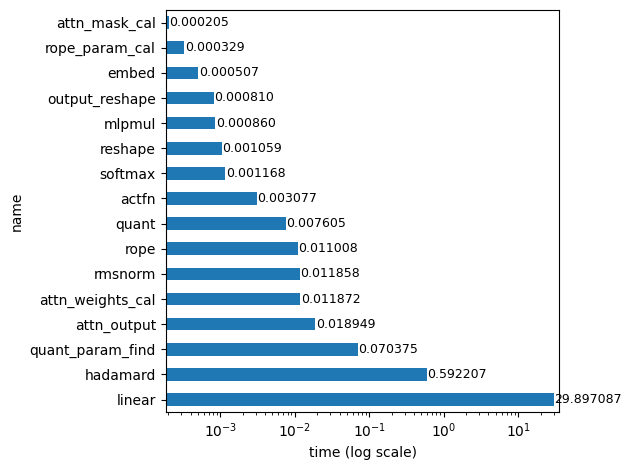

PREFILL: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          61.3464667797089 61.3332319259644
top.vproj                                                                        32         59.0227839946747 59.0152602195740
top.vproj.linear                                                                 32         58.9860711097717 0.0000000000000
top.downproj                                                                     32         1.2439763545990 1.2423613071442
top.downproj.matmul_hadU_cuda                                                    32         0.9828531742096 0.0000000000000
top.downproj.linear                                                              32         0.2595081329346 0.0000000000000
top.upproj                                                                   

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


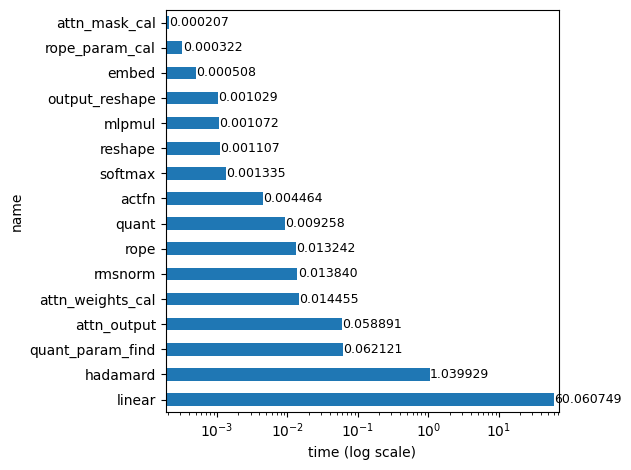

PREFILL: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          121.9241564273834 121.9070270061493
top.vproj                                                                        32         117.9033041000366 117.8944354057312
top.vproj.linear                                                                 32         117.8581988811493 0.0000000000000
top.downproj                                                                     32         2.2387845516205 2.2368714809418
top.downproj.matmul_hadU_cuda                                                    32         1.8147726058960 0.0000000000000
top.upproj                                                                       32         0.4256610870361 0.4244034290314
top.upproj.linear                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


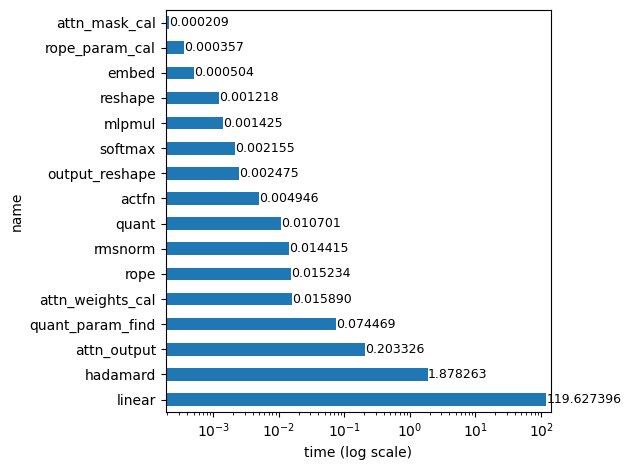

PREFILL: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          231.5919003486633 231.5746903419495
top.vproj                                                                        32         224.1153850555420 224.1045188903809
top.vproj.linear                                                                 32         224.0594315528870 0.0000000000000
top.downproj                                                                     32         4.2234785556793 4.2214374542236
top.downproj.matmul_hadU_cuda                                                    32         3.5078296661377 0.0000000000000
top.downproj.linear                                                              32         0.7136077880859 0.0000000000000
top.upproj                                                              

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


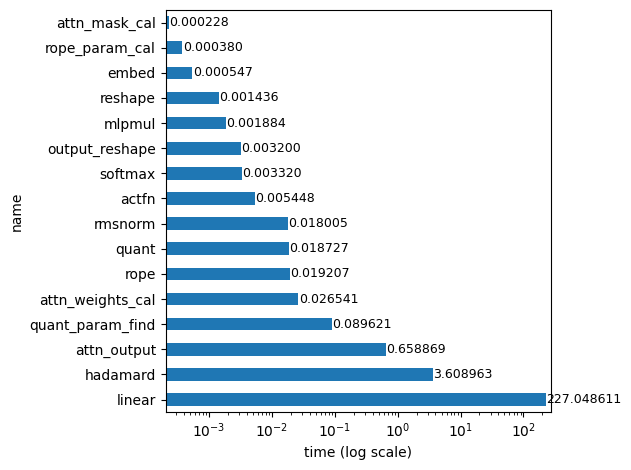

PREFILL: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          413.4495193958282 413.4272136688232
top.vproj                                                                        32         398.0396547317505 398.0263781547546
top.vproj.linear                                                                 32         397.9609918594360 0.0000000000000
top.downproj                                                                     32         8.2016608715057 8.1992044448853
top.downproj.matmul_hadU_cuda                                                    32         6.8294215202332 0.0000000000000
top.attn_output                                                                  32         2.3884789943695 0.0000000000000
top.downproj.linear                                                    

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


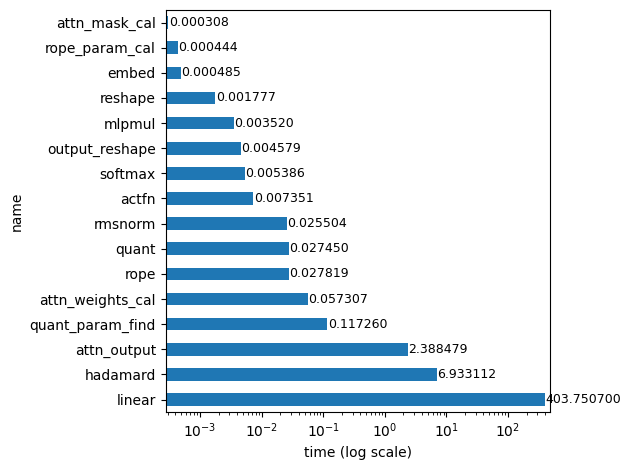

GENERATE: bs 1, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          4.3239192962646 4.3126313686371
top.vproj                                                                        32         3.8789331912994 3.8731582164764
top.vproj.linear                                                                 32         3.8533792495728 0.0000000000000
top.downproj                                                                     32         0.1673309803009 0.1660988330841
top.downproj.matmul_hadU_cuda                                                    32         0.1142678260803 0.0000000000000
top.apply_rope                                                                   32         0.0726468563080 0.0651464462280
top.downproj.linear                                                              3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


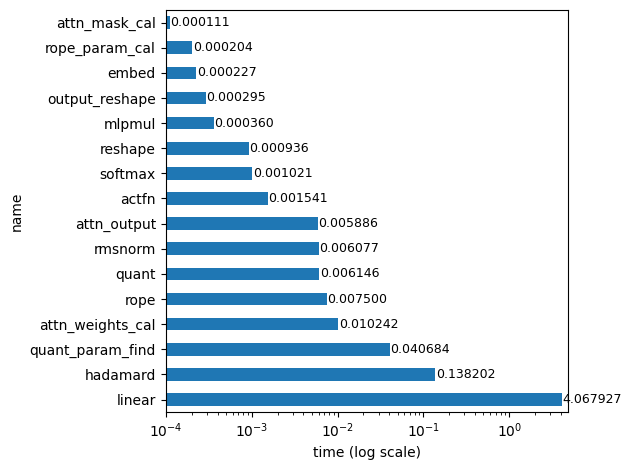

GENERATE: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          4.4510819911957 4.4385347366333
top.vproj                                                                        32         3.9773070812225 3.9713582992554
top.vproj.linear                                                                 32         3.9483928680420 0.0000000000000
top.downproj                                                                     32         0.1699666976929 0.1686675548553
top.downproj.matmul_hadU_cuda                                                    32         0.1153416633606 0.0000000000000
top.apply_rope                                                                   32         0.0712282657623 0.0637357234955
top.upproj                                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


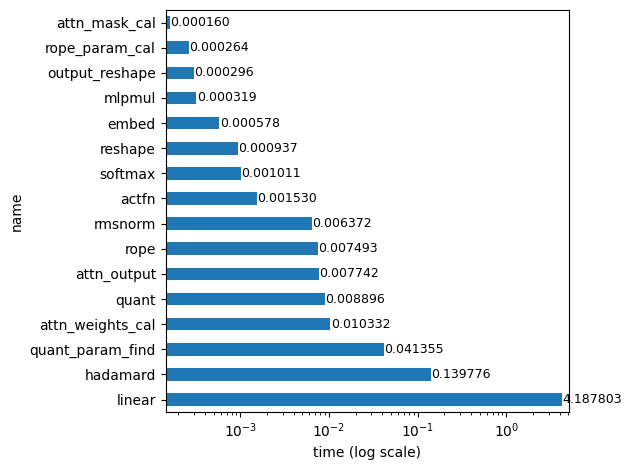

GENERATE: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          4.2540223598480 4.2413022518158
top.vproj                                                                        32         3.8210206031799 3.8150930404663
top.vproj.linear                                                                 32         3.7953450679779 0.0000000000000
top.downproj                                                                     32         0.1632814407349 0.1620082855225
top.downproj.matmul_hadU_cuda                                                    32         0.1144990921021 0.0000000000000
top.apply_rope                                                                   32         0.0766503810883 0.0691640377045
top.downproj.linear                                                              

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


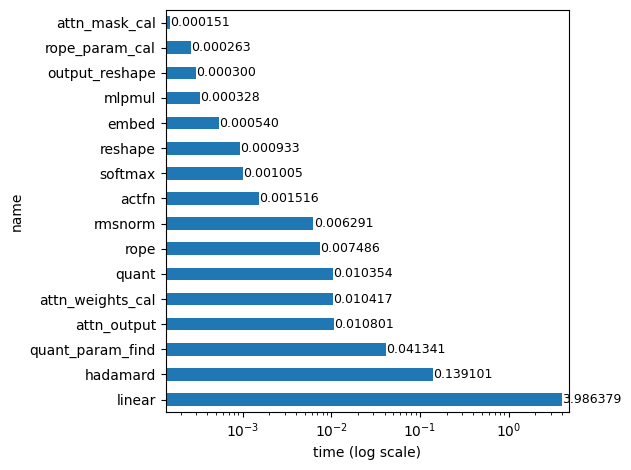

GENERATE: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          4.3281919956207 4.3136837482452
top.vproj                                                                        32         3.8496086597443 3.8435101509094
top.vproj.linear                                                                 32         3.8233323097229 0.0000000000000
top.downproj                                                                     32         0.1690299510956 0.1677205562592
top.downproj.matmul_hadU_cuda                                                    32         0.1145758628845 0.0000000000000
top.apply_rope                                                                   32         0.0727450847626 0.0650918483734
top.upproj                                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


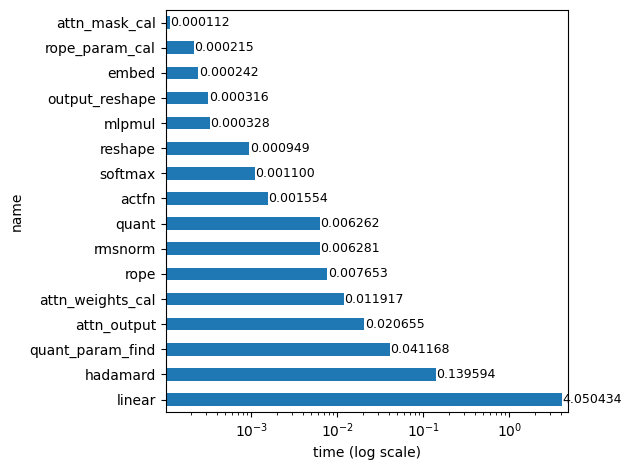

GENERATE: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          4.2874877452850 4.2704858779907
top.vproj                                                                        32         3.8536043167114 3.8477461338043
top.vproj.linear                                                                 32         3.8275806903839 0.0000000000000
top.downproj                                                                     32         0.1516044139862 0.1503708362579
top.downproj.matmul_hadU_cuda                                                    32         0.1097991466522 0.0000000000000
top.apply_rope                                                                   32         0.0717976093292 0.0642578601837
top.upproj                                                                      

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


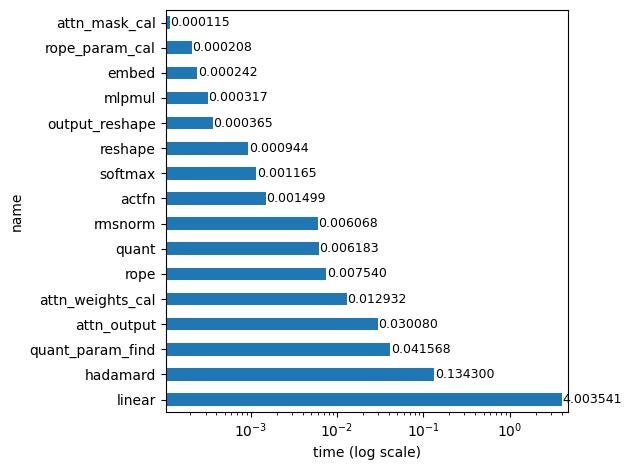

PREFILL: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          61.5609316825867 61.5473299026489
top.vproj                                                                        32         59.5090725421906 59.5007255077362
top.vproj.linear                                                                 32         59.4696731567383 0.0000000000000
top.downproj                                                                     32         1.1756293773651 1.1739461421967
top.downproj.matmul_hadU_cuda                                                    32         0.9802970886230 0.0000000000000
top.downproj.linear                                                              32         0.1936490535736 0.0000000000000
top.gateproj                                                                  

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


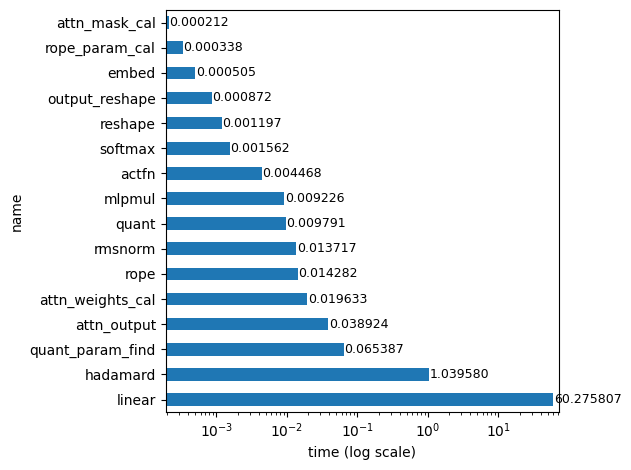

PREFILL: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          120.2443168163300 120.2300167083740
top.vproj                                                                        32         116.5510609149933 116.5424363613129
top.vproj.linear                                                                 32         116.5082240104675 0.0000000000000
top.downproj                                                                     32         2.1932754516602 2.1913936138153
top.downproj.matmul_hadU_cuda                                                    32         1.8344924449921 0.0000000000000
top.upproj                                                                       32         0.3608996868134 0.3596758842468
top.upproj.linear                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


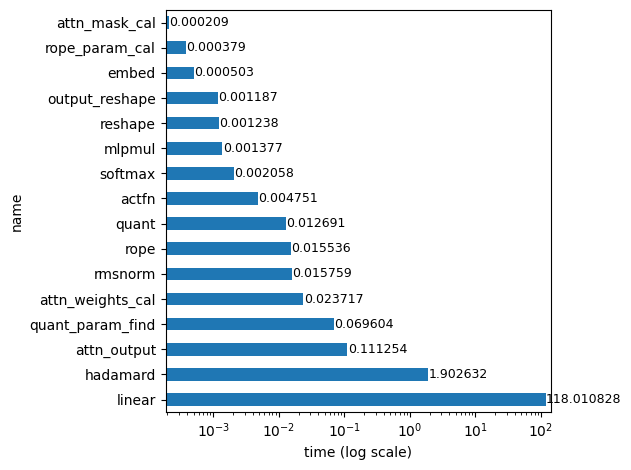

PREFILL: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          230.9734339714050 230.9535510540009
top.vproj                                                                        32         223.9268906116486 223.9162402153015
top.vproj.linear                                                                 32         223.8284149169922 0.0000000000000
top.downproj                                                                     32         4.2219278812408 4.2198138237000
top.downproj.matmul_hadU_cuda                                                    32         3.5157244205475 0.0000000000000
top.downproj.linear                                                              32         0.7040894031525 0.0000000000000
top.upproj                                                              

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


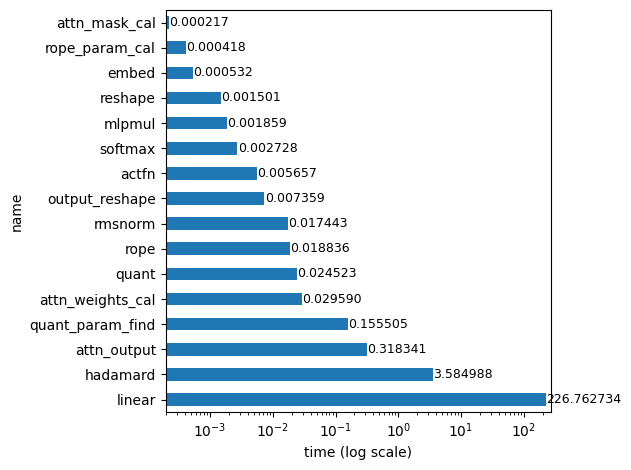

PREFILL: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          424.0592236518860 424.0390553474426
top.vproj                                                                        32         410.0648705959320 410.0528604984283
top.vproj.linear                                                                 32         409.9946680068970 0.0000000000000
top.downproj                                                                     32         8.2059099674225 8.2035703659058
top.downproj.matmul_hadU_cuda                                                    32         6.8360154628754 0.0000000000000
top.upproj                                                                       32         1.3699901103973 1.3683528900146
top.upproj.linear                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


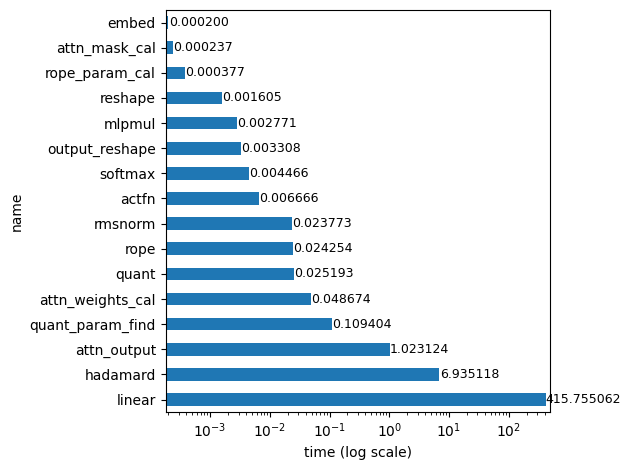

PREFILL: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          707.0659687519073 707.0375988483429
top.vproj                                                                        32         677.8614604473114 677.8479611873627
top.vproj.linear                                                                 32         677.7732973098755 0.0000000000000
top.downproj                                                                     32         16.1925437450409 16.1895616054535
top.downproj.matmul_hadU_cuda                                                    32         13.4759464263916 0.0000000000000
top.attn_output                                                                  32         3.7157442569733 0.0000000000000
top.upproj                                                          

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


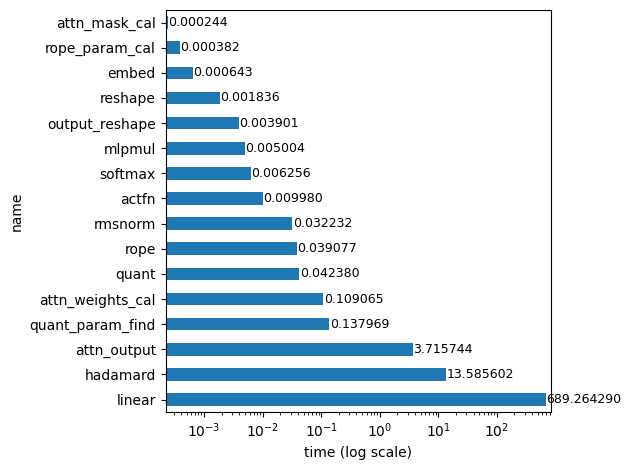

GENERATE: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          8.3420293331146 8.3277022838593
top.vproj                                                                        32         7.5568587779999 7.5506765842438
top.vproj.linear                                                                 32         7.5296604633331 0.0000000000000
top.downproj                                                                     32         0.3003442287445 0.2989857196808
top.downproj.matmul_hadU_cuda                                                    32         0.1939496994019 0.0000000000000
top.upproj                                                                       32         0.1052026748657 0.1042613983154
top.downproj.linear                                                              3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


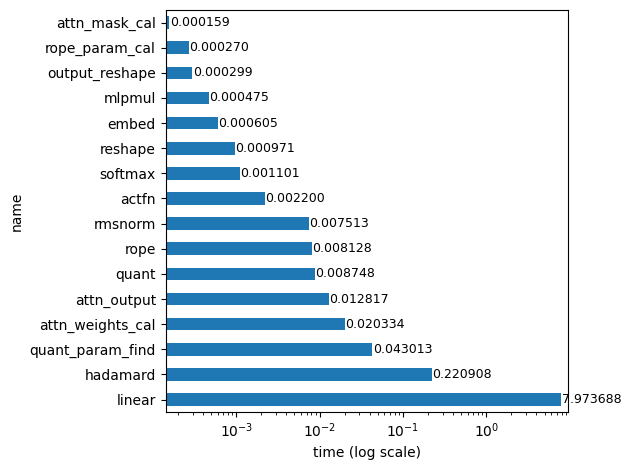

GENERATE: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          8.2667422294617 8.2537555694580
top.vproj                                                                        32         7.6010942459106 7.5950922966003
top.vproj.linear                                                                 32         7.5743124485016 0.0000000000000
top.downproj                                                                     32         0.2768948078156 0.2755861282349
top.downproj.matmul_hadU_cuda                                                    32         0.1933062076569 0.0000000000000
top.downproj.linear                                                              32         0.0822799205780 0.0000000000000
top.apply_rope                                                                   

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


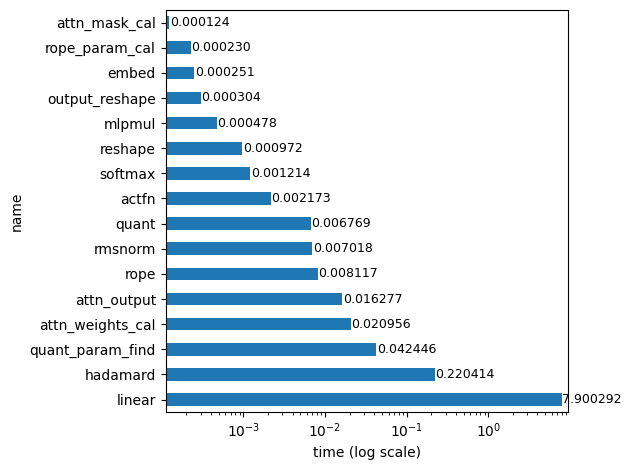

GENERATE: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          8.1471726894379 8.1317362785339
top.vproj                                                                        32         7.5121042728424 7.5059144496918
top.vproj.linear                                                                 32         7.4845676422119 0.0000000000000
top.downproj                                                                     32         0.2560794353485 0.2547056674957
top.downproj.matmul_hadU_cuda                                                    32         0.1947951316833 0.0000000000000
top.apply_rope                                                                   32         0.0793399810791 0.0711410045624
top.upproj                                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


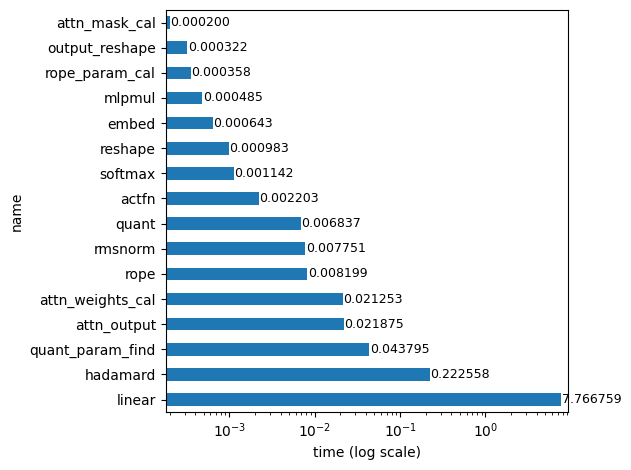

GENERATE: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          8.1825439929962 8.1660275459290
top.vproj                                                                        32         7.5306434631348 7.5245835781097
top.vproj.linear                                                                 32         7.5037260055542 0.0000000000000
top.downproj                                                                     32         0.2665054798126 0.2651824951172
top.downproj.matmul_hadU_cuda                                                    32         0.1936502456665 0.0000000000000
top.apply_rope                                                                   32         0.0791437625885 0.0710351467133
top.downproj.linear                                                              

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


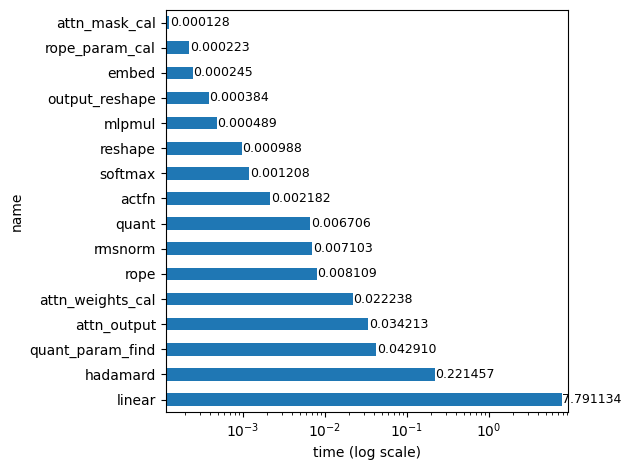

GENERATE: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          8.1926419734955 8.1701555252075
top.vproj                                                                        32         7.5551130771637 7.5489997863770
top.vproj.linear                                                                 32         7.5280709266663 0.0000000000000
top.downproj                                                                     32         0.2586340904236 0.2573158740997
top.downproj.matmul_hadU_cuda                                                    32         0.1935832500458 0.0000000000000
top.apply_rope                                                                   32         0.0781064033508 0.0699853897095
top.downproj.linear                                                             

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


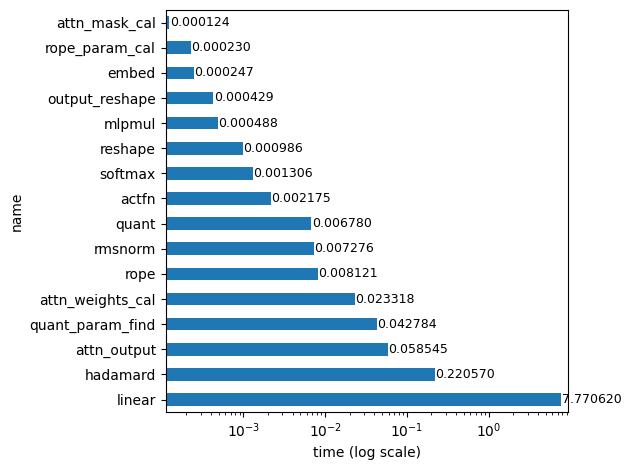

PREFILL: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          123.5163776874542 123.5015387535095
top.vproj                                                                        32         119.6688373088837 119.6605262756348
top.vproj.linear                                                                 32         119.6244988441467 0.0000000000000
top.downproj                                                                     32         2.2298052310944 2.2279546260834
top.downproj.matmul_hadU_cuda                                                    32         1.8312203884125 0.0000000000000
top.upproj                                                                       32         0.4015207290649 0.4002795219421
top.upproj.linear                                                        

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


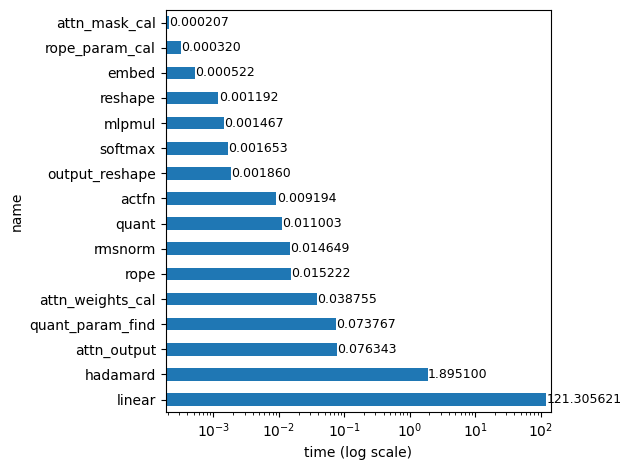

PREFILL: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          233.7776541709900 233.7608878612518
top.vproj                                                                        32         226.6411209106445 226.6314017772675
top.vproj.linear                                                                 32         226.5877451896667 0.0000000000000
top.downproj                                                                     32         4.2533543109894 4.2513787746429
top.downproj.matmul_hadU_cuda                                                    32         3.5050706863403 0.0000000000000
top.gateproj                                                                     32         0.7470407485962 0.7456624507904
top.downproj.linear                                                     

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


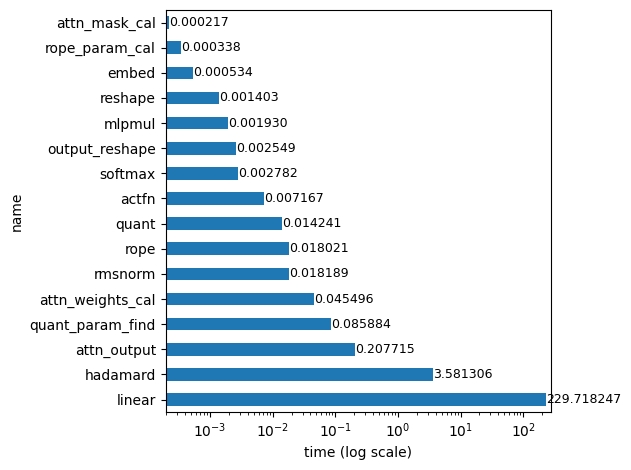

PREFILL: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          412.9735364913940 412.9531033039093
top.vproj                                                                        32         399.4162971973419 399.4052243232727
top.vproj.linear                                                                 32         399.3523752689362 0.0000000000000
top.downproj                                                                     32         8.1934604644775 8.1912117004395
top.downproj.matmul_hadU_cuda                                                    32         6.8119165897369 0.0000000000000
top.upproj                                                                       32         1.3815228939056 1.3800537586212
top.upproj.linear                                                       

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


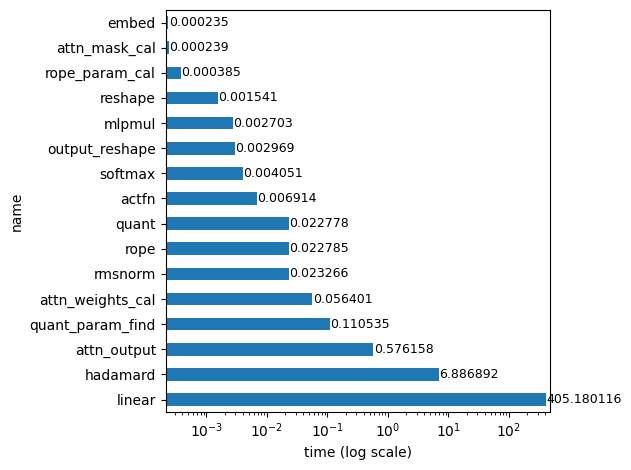

PREFILL: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          716.7866921424866 716.7613651752472
top.vproj                                                                        32         689.3881480693817 689.3754606246948
top.vproj.linear                                                                 32         689.3086655139923 0.0000000000000
top.downproj                                                                     32         16.1735227108002 16.1706411838531
top.downproj.matmul_hadU_cuda                                                    32         13.4540376663208 0.0000000000000
top.upproj                                                                       32         2.7322537899017 2.7302920818329
top.upproj.linear                                                    

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


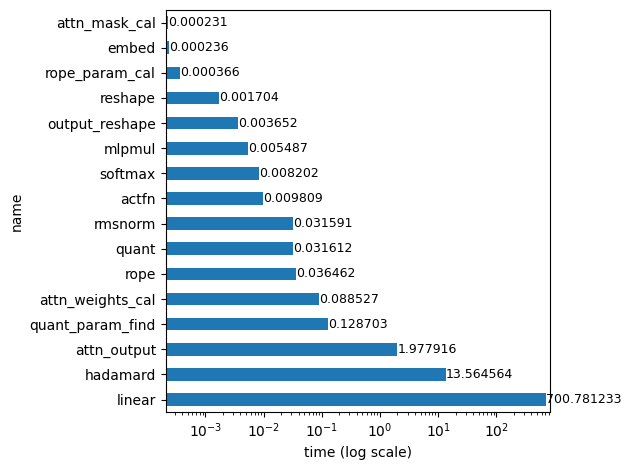

PREFILL: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          1431.2511646747589 1431.2080426216125
top.vproj                                                                        32         1373.5750567913055 1373.5582268238068
top.vproj.linear                                                                 32         1373.4529509544373 0.0000000000000
top.downproj                                                                     32         32.0275132656097 32.0230748653412
top.downproj.matmul_hadU_cuda                                                    32         26.6284055709839 0.0000000000000
top.attn_output                                                                  32         7.3496522903442 0.0000000000000
top.upproj                                                     

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


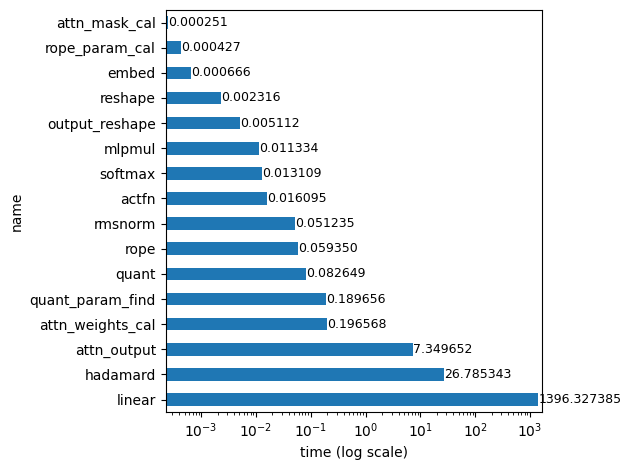

GENERATE: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          16.0778429508209 16.0625848770142
top.vproj                                                                        32         15.0721476078033 15.0657243728638
top.vproj.linear                                                                 32         15.0435450077057 0.0000000000000
top.downproj                                                                     32         0.4489977359772 0.4475610256195
top.downproj.matmul_hadU_cuda                                                    32         0.3427598476410 0.0000000000000
top.gateproj                                                                     32         0.1319410800934 0.1310145854950
top.gateproj.linear                                                          

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


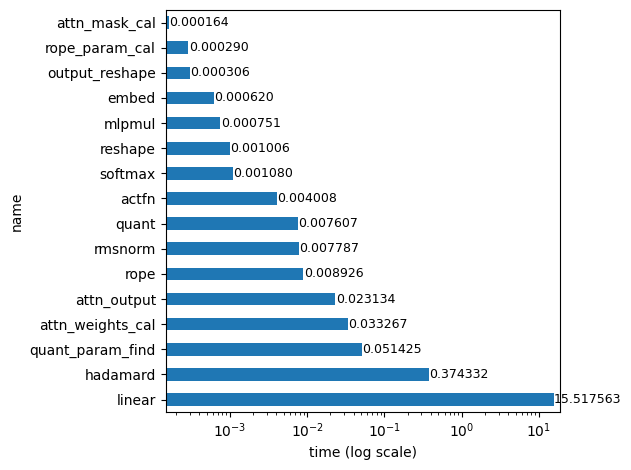

GENERATE: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          15.7215998172760 15.7056784629822
top.vproj                                                                        32         14.8488099575043 14.8424210548401
top.vproj.linear                                                                 32         14.8173692226410 0.0000000000000
top.downproj                                                                     32         0.4179956912994 0.4166138172150
top.downproj.matmul_hadU_cuda                                                    32         0.3369030952454 0.0000000000000
top.apply_rope                                                                   32         0.0925438404083 0.0834391117096
top.gateproj                                                                

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


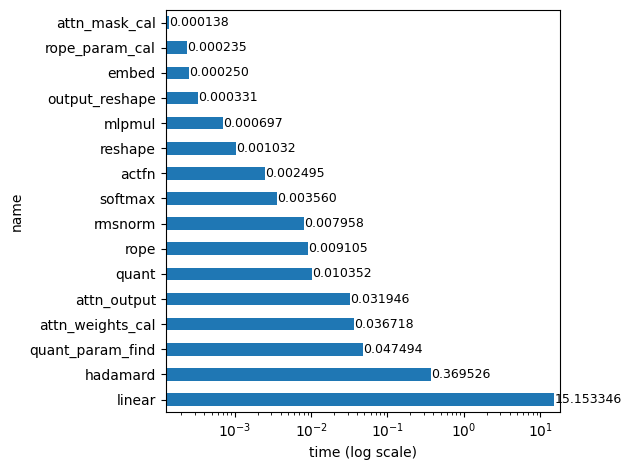

GENERATE: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          15.4979698657990 15.4794750213623
top.vproj                                                                        32         14.5647115707397 14.5585451126099
top.vproj.linear                                                                 32         14.5368118286133 0.0000000000000
top.downproj                                                                     32         0.4296734333038 0.4283366203308
top.downproj.matmul_hadU_cuda                                                    32         0.3362519741058 0.0000000000000
top.upproj                                                                       32         0.0936310291290 0.0928390026093
top.upproj.linear                                                           

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


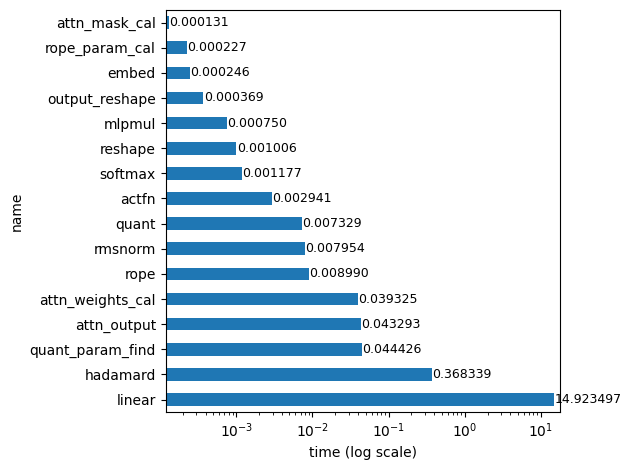

GENERATE: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          15.4401280879974 15.4183135032654
top.vproj                                                                        32         14.5836617946625 14.5771970748901
top.vproj.linear                                                                 32         14.5549783706665 0.0000000000000
top.downproj                                                                     32         0.4018464088440 0.4004695415497
top.downproj.matmul_hadU_cuda                                                    32         0.3365349769592 0.0000000000000
top.apply_rope                                                                   32         0.0910296440125 0.0820417404175
top.attn_output                                                             

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


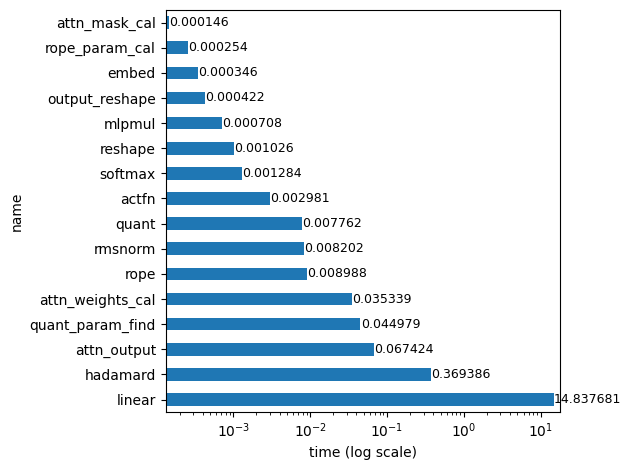

GENERATE: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          15.4019677639008 15.3705062866211
top.vproj                                                                        32         14.4737279415131 14.4675195217133
top.vproj.linear                                                                 32         14.4456720352173 0.0000000000000
top.downproj                                                                     32         0.4058060646057 0.4044487476349
top.downproj.matmul_hadU_cuda                                                    32         0.3381640911102 0.0000000000000
top.attn_output                                                                  32         0.1158394813538 0.0000000000000
top.apply_rope                                                             

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


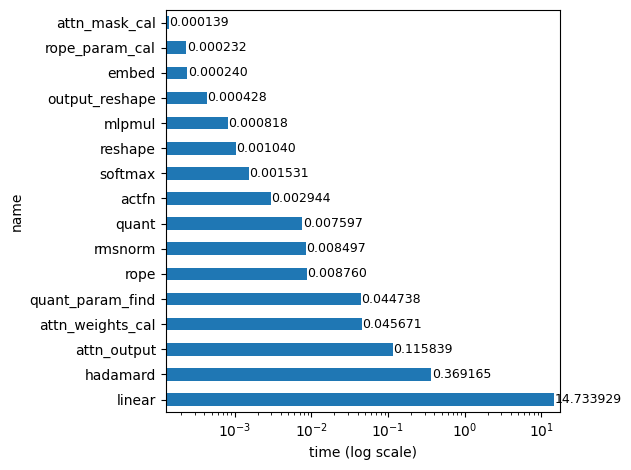

In [40]:
batch_size = [1, 2, 4]
past_seq_len = [8, 16, 32, 64, 128]
seq_len = [8, 16, 32, 64, 128]

for bs in batch_size:
  # prefill
  for sl in seq_len:
    print(f"PREFILL: bs {bs}, sl {sl}")
    run_profile(model, bs, 0, sl, "cpu", f"./prof/bs{bs}_sl{sl}_prf.png") 
  
  # generate
  for sl in past_seq_len:
    print(f"GENERATE: bs {bs}, sl {sl}")
    run_profile(model, bs, sl, 1, "cpu", f"./prof/bs{bs}_sl{sl}_gen.png")

PREFILL: bs 1, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0872666835785 0.0811908245087
top.apply_rope                                                                   32         0.0315468311310 0.0240976810455
top.vproj                                                                        32         0.0205028057098 0.0164453983307
top.apply_rope.k_head_quantize                                                   32         0.0185987949371 0.0162701606750
top.apply_rope.k_head_quantize.find_params                                       32         0.0136506557465 0.0000000000000
top.vproj.find_params                                                            32         0.0130965709686 0.0112884044647
top.vproj.find_params.find_params_per_token_groupwise                            32

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


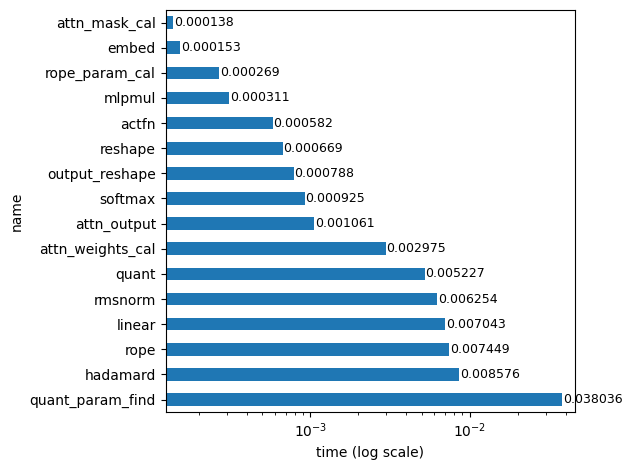

PREFILL: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0864846706390 0.0806515216827
top.apply_rope                                                                   32         0.0312206745148 0.0238609313965
top.vproj                                                                        32         0.0205745697021 0.0166244506836
top.apply_rope.k_head_quantize                                                   32         0.0184576511383 0.0161824226379
top.apply_rope.k_head_quantize.find_params                                       32         0.0135583877563 0.0000000000000
top.vproj.find_params                                                            32         0.0132970809937 0.0114934444427
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


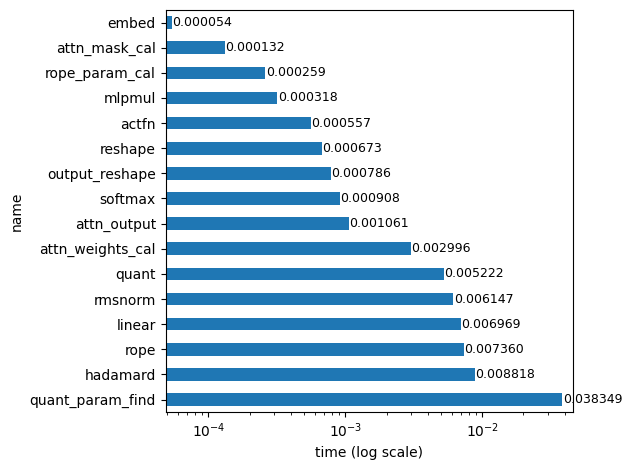

PREFILL: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0879540443420 0.0820484161377
top.apply_rope                                                                   32         0.0314440727234 0.0240669250488
top.vproj                                                                        32         0.0204772949219 0.0165462493896
top.apply_rope.k_head_quantize                                                   32         0.0186107158661 0.0163180828094
top.apply_rope.k_head_quantize.find_params                                       32         0.0136761665344 0.0000000000000
top.vproj.find_params                                                            32         0.0131742954254 0.0113601684570
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


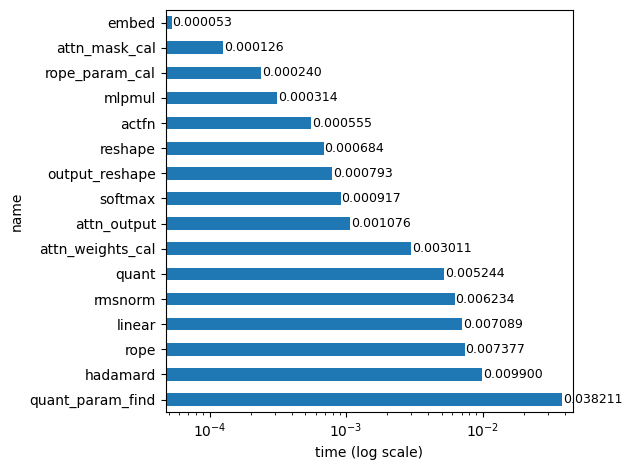

PREFILL: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0953073501587 0.0890655517578
top.apply_rope                                                                   32         0.0389418601990 0.0313084125519
top.apply_rope.k_head_quantize                                                   32         0.0257861614227 0.0232033729553
top.vproj                                                                        32         0.0207245349884 0.0167379379272
top.apply_rope.k_head_quantize.find_params                                       32         0.0164396762848 0.0000000000000
top.vproj.find_params                                                            32         0.0132791996002 0.0114750862122
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


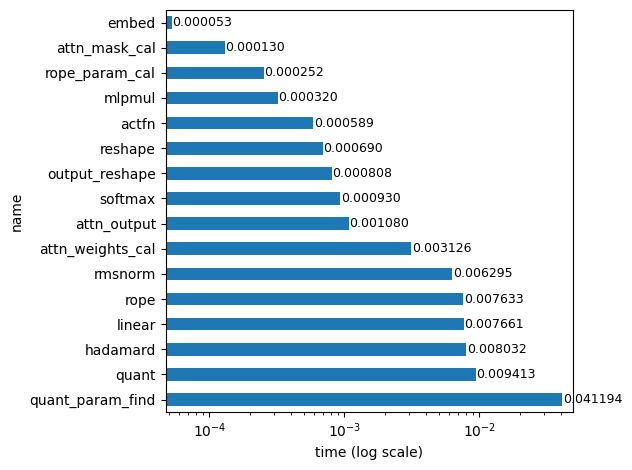

PREFILL: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.1005446910858 0.0941965579987
top.apply_rope                                                                   32         0.0341622829437 0.0263447761536
top.vproj                                                                        32         0.0293715000153 0.0247023105621
top.apply_rope.k_head_quantize                                                   32         0.0205378532410 0.0179965496063
top.apply_rope.k_head_quantize.find_params                                       32         0.0153098106384 0.0000000000000
top.vproj.find_params                                                            32         0.0134556293488 0.0115230083466
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


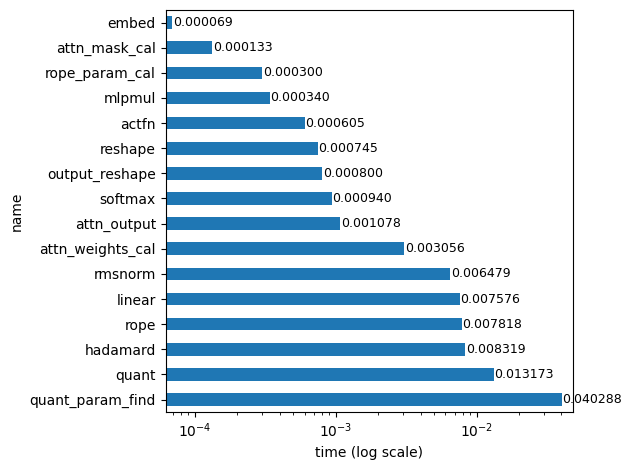

GENERATE: bs 1, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0849735736847 0.0780339241028
top.apply_rope                                                                   32         0.0307567119598 0.0233993530273
top.vproj                                                                        32         0.0202753543854 0.0163292884827
top.apply_rope.k_head_quantize                                                   32         0.0188000202179 0.0165083408356
top.apply_rope.k_head_quantize.find_params                                       32         0.0138728618622 0.0000000000000
top.vproj.find_params                                                            32         0.0129742622375 0.0111954212189
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


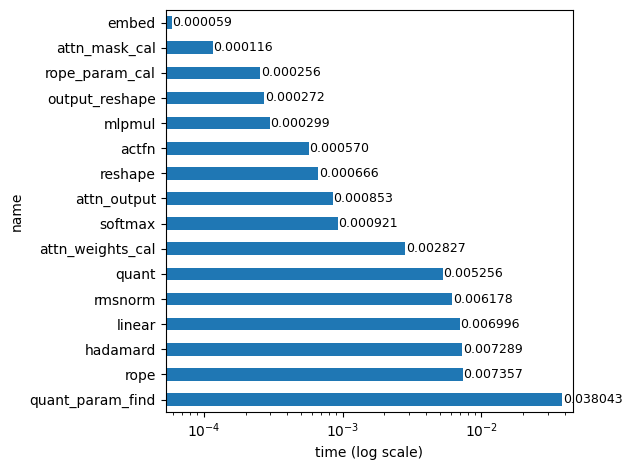

GENERATE: bs 1, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0847358703613 0.0777807235718
top.apply_rope                                                                   32         0.0305218696594 0.0231730937958
top.vproj                                                                        32         0.0203795433044 0.0163946151733
top.apply_rope.k_head_quantize                                                   32         0.0186083316803 0.0163414478302
top.apply_rope.k_head_quantize.find_params                                       32         0.0136928558350 0.0000000000000
top.vproj.find_params                                                            32         0.0130527019501 0.0112526416779
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


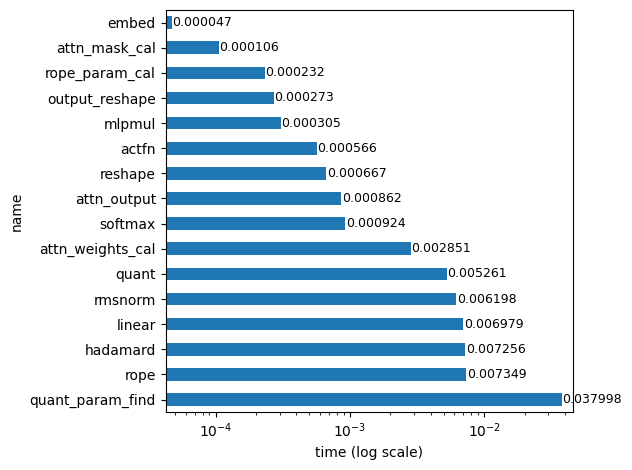

GENERATE: bs 1, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0836544036865 0.0767982006073
top.apply_rope                                                                   32         0.0300586223602 0.0227973461151
top.vproj                                                                        32         0.0201518535614 0.0162677764893
top.apply_rope.k_head_quantize                                                   32         0.0182611942291 0.0160255432129
top.apply_rope.k_head_quantize.find_params                                       32         0.0134279727936 0.0000000000000
top.vproj.find_params                                                            32         0.0129563808441 0.0111734867096
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


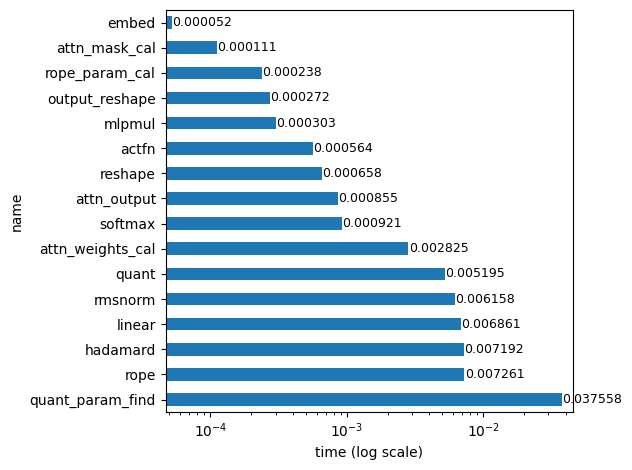

GENERATE: bs 1, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0905294418335 0.0783462524414
top.apply_rope                                                                   32         0.0307621955872 0.0234167575836
top.vproj                                                                        32         0.0203714370728 0.0163795948029
top.apply_rope.k_head_quantize                                                   32         0.0188472270966 0.0165870189667
top.apply_rope.k_head_quantize.find_params                                       32         0.0139596462250 0.0000000000000
top.vproj.find_params                                                            32         0.0130417346954 0.0112287998199
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


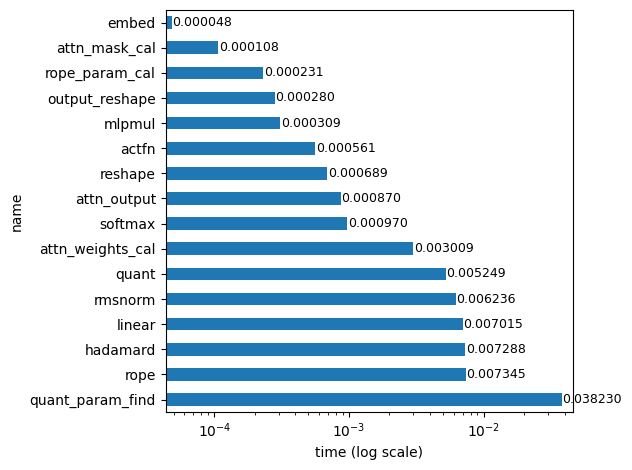

GENERATE: bs 1, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0849726200104 0.0775291919708
top.apply_rope                                                                   32         0.0303168296814 0.0229492187500
top.vproj                                                                        32         0.0203771591187 0.0164287090302
top.apply_rope.k_head_quantize                                                   32         0.0183796882629 0.0161187648773
top.apply_rope.k_head_quantize.find_params                                       32         0.0134911537170 0.0000000000000
top.vproj.find_params                                                            32         0.0130801200867 0.0112829208374
top.vproj.find_params.find_params_per_token_groupwise                           

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


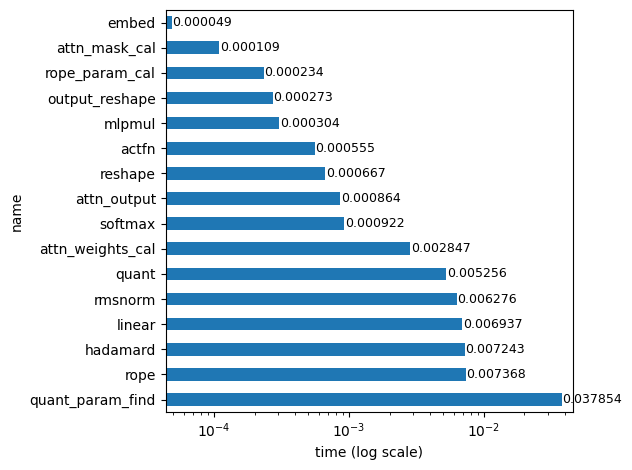

PREFILL: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0873458385468 0.0814802646637
top.apply_rope                                                                   32         0.0315780639648 0.0241496562958
top.vproj                                                                        32         0.0205583572388 0.0165607929230
top.apply_rope.k_head_quantize                                                   32         0.0187106132507 0.0164327621460
top.apply_rope.k_head_quantize.find_params                                       32         0.0138192176819 0.0000000000000
top.vproj.find_params                                                            32         0.0131971836090 0.0113778114319
top.vproj.find_params.find_params_per_token_groupwise                            32

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


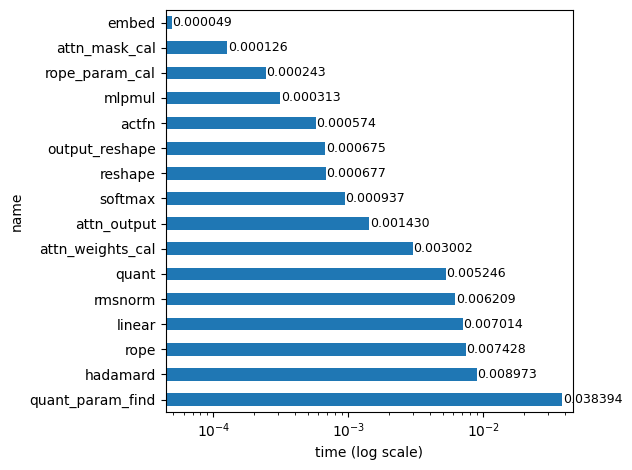

PREFILL: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0887482166290 0.0827479362488
top.apply_rope                                                                   32         0.0315475463867 0.0241446495056
top.vproj                                                                        32         0.0206868648529 0.0167365074158
top.apply_rope.k_head_quantize                                                   32         0.0187034606934 0.0164279937744
top.apply_rope.k_head_quantize.find_params                                       32         0.0137794017792 0.0000000000000
top.vproj.find_params                                                            32         0.0133078098297 0.0114731788635
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


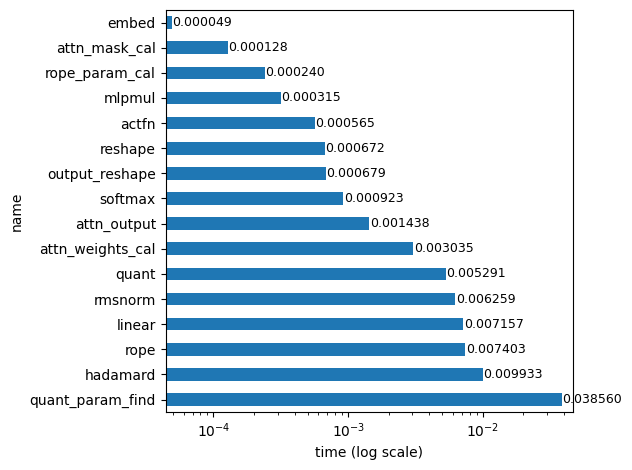

PREFILL: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0910089015961 0.0850687026978
top.apply_rope                                                                   32         0.0356931686401 0.0281026363373
top.apply_rope.k_head_quantize                                                   32         0.0226464271545 0.0201854705811
top.vproj                                                                        32         0.0207524299622 0.0167808532715
top.apply_rope.k_head_quantize.find_params                                       32         0.0136620998383 0.0000000000000
top.vproj.find_params                                                            32         0.0133578777313 0.0115525722504
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


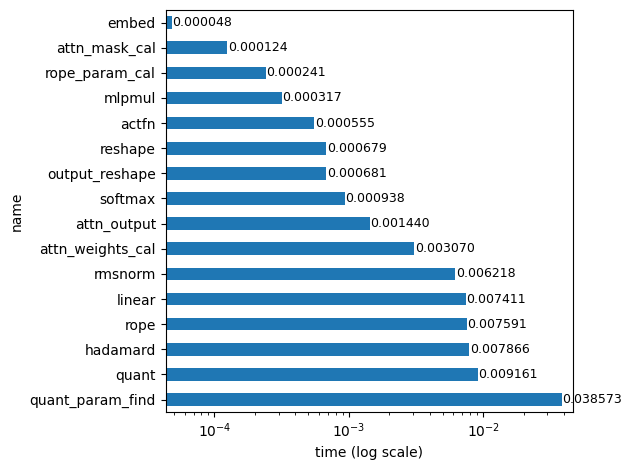

PREFILL: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0949757099152 0.0890607833862
top.apply_rope                                                                   32         0.0319101810455 0.0242276191711
top.vproj                                                                        32         0.0286161899567 0.0242171287537
top.apply_rope.k_head_quantize                                                   32         0.0186893939972 0.0163793563843
top.apply_rope.k_head_quantize.find_params                                       32         0.0137336254120 0.0000000000000
top.vproj.find_params                                                            32         0.0132038593292 0.0114223957062
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


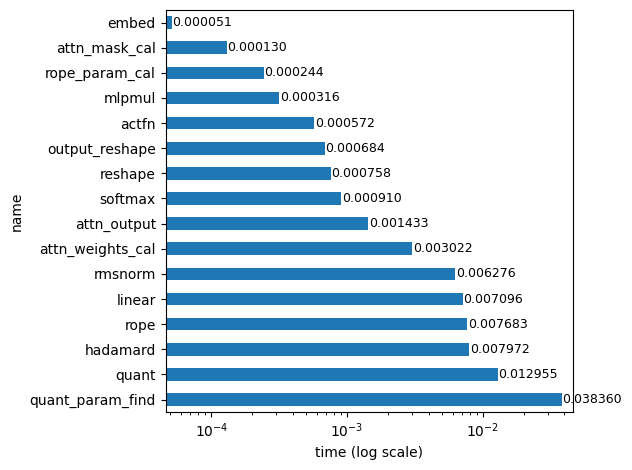

PREFILL: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0987439155579 0.0928461551666
top.apply_rope                                                                   32         0.0323739051819 0.0248835086823
top.vproj                                                                        32         0.0300269126892 0.0261297225952
top.apply_rope.k_head_quantize                                                   32         0.0193963050842 0.0170938968658
top.apply_rope.k_head_quantize.find_params                                       32         0.0138921737671 0.0000000000000
top.vproj.find_params                                                            32         0.0132293701172 0.0114264488220
top.vproj.asmy_ste_quantize                                                      

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


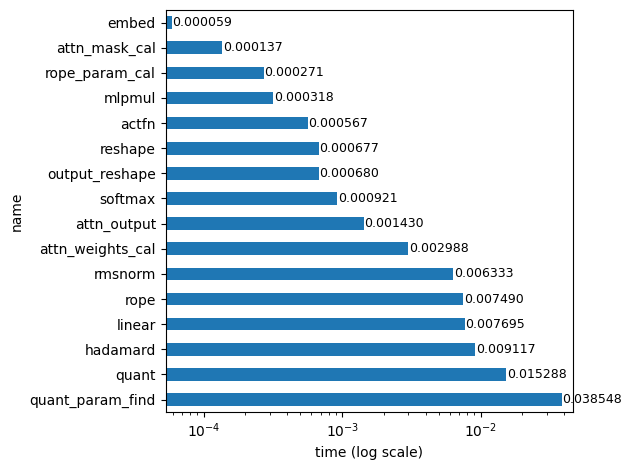

GENERATE: bs 2, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0849206447601 0.0780241489410
top.apply_rope                                                                   32         0.0307116508484 0.0233511924744
top.vproj                                                                        32         0.0205101966858 0.0165348052979
top.apply_rope.k_head_quantize                                                   32         0.0187880992889 0.0164818763733
top.apply_rope.k_head_quantize.find_params                                       32         0.0138115882874 0.0000000000000
top.vproj.find_params                                                            32         0.0131964683533 0.0113992691040
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


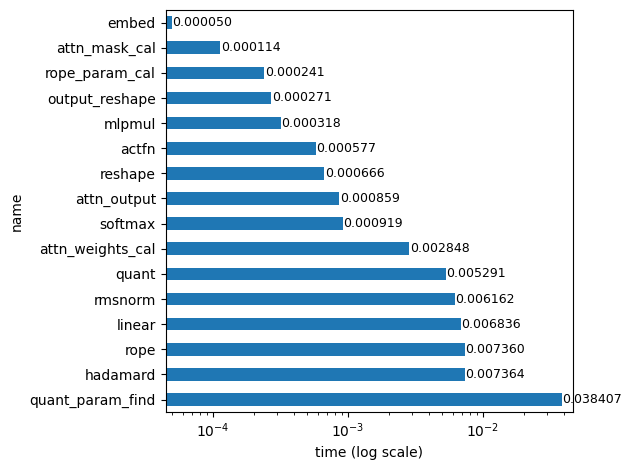

GENERATE: bs 2, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0852181911469 0.0780422687531
top.apply_rope                                                                   32         0.0303699970245 0.0229868888855
top.vproj                                                                        32         0.0204100608826 0.0164475440979
top.apply_rope.k_head_quantize                                                   32         0.0184440612793 0.0161843299866
top.apply_rope.k_head_quantize.find_params                                       32         0.0135307312012 0.0000000000000
top.vproj.find_params                                                            32         0.0130636692047 0.0112636089325
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


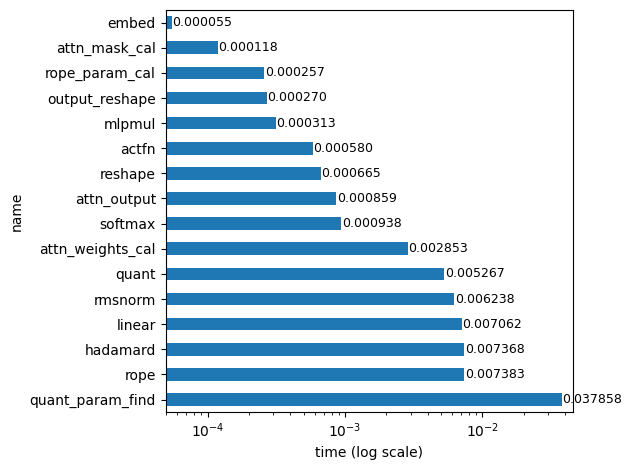

GENERATE: bs 2, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0847246646881 0.0776607990265
top.apply_rope                                                                   32         0.0302994251251 0.0229022502899
top.vproj                                                                        32         0.0204508304596 0.0164756774902
top.apply_rope.k_head_quantize                                                   32         0.0183541774750 0.0160918235779
top.apply_rope.k_head_quantize.find_params                                       32         0.0134868621826 0.0000000000000
top.vproj.find_params                                                            32         0.0130679607391 0.0112907886505
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


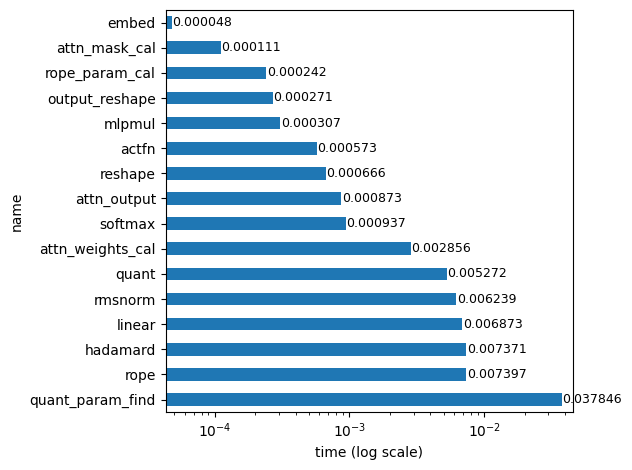

GENERATE: bs 2, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0862598419189 0.0791883468628
top.apply_rope                                                                   32         0.0311598777771 0.0236892700195
top.vproj                                                                        32         0.0207614898682 0.0167601108551
top.apply_rope.k_head_quantize                                                   32         0.0190196037292 0.0167243480682
top.apply_rope.k_head_quantize.find_params                                       32         0.0140981674194 0.0000000000000
top.vproj.find_params                                                            32         0.0133247375488 0.0115325450897
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


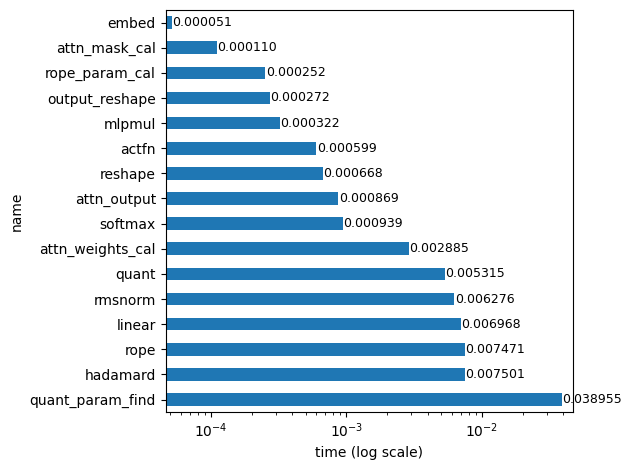

GENERATE: bs 2, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0861260890961 0.0787961483002
top.apply_rope                                                                   32         0.0305433273315 0.0230998992920
top.vproj                                                                        32         0.0207381248474 0.0167107582092
top.apply_rope.k_head_quantize                                                   32         0.0185170173645 0.0162217617035
top.apply_rope.k_head_quantize.find_params                                       32         0.0136201381683 0.0000000000000
top.vproj.find_params                                                            32         0.0132656097412 0.0114674568176
top.vproj.find_params.find_params_per_token_groupwise                           

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


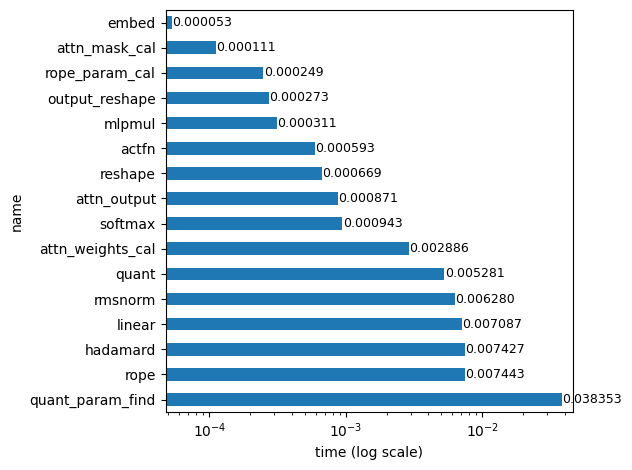

PREFILL: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0883934497833 0.0824239253998
top.apply_rope                                                                   32         0.0314261913300 0.0240058898926
top.vproj                                                                        32         0.0225462913513 0.0185697078705
top.apply_rope.k_head_quantize                                                   32         0.0185666084290 0.0162885189056
top.apply_rope.k_head_quantize.find_params                                       32         0.0136680603027 0.0000000000000
top.vproj.find_params                                                            32         0.0131096839905 0.0113482475281
top.vproj.find_params.find_params_per_token_groupwise                            32

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


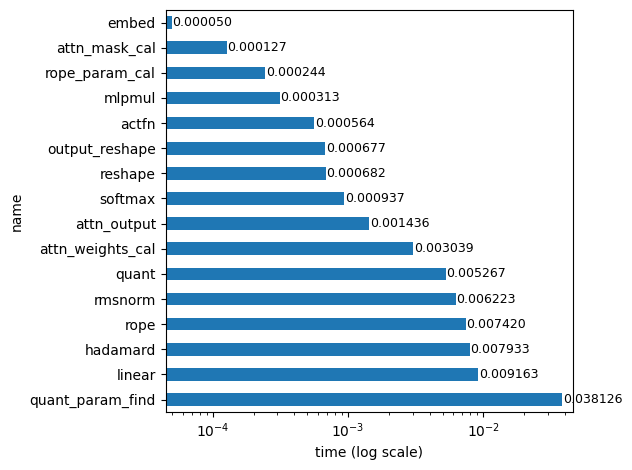

PREFILL: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0902411937714 0.0841114521027
top.apply_rope                                                                   32         0.0319788455963 0.0245039463043
top.vproj                                                                        32         0.0205664634705 0.0165870189667
top.apply_rope.k_head_quantize                                                   32         0.0190515518188 0.0167272090912
top.apply_rope.k_head_quantize.find_params                                       32         0.0140621662140 0.0000000000000
top.vproj.find_params                                                            32         0.0131657123566 0.0113844871521
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


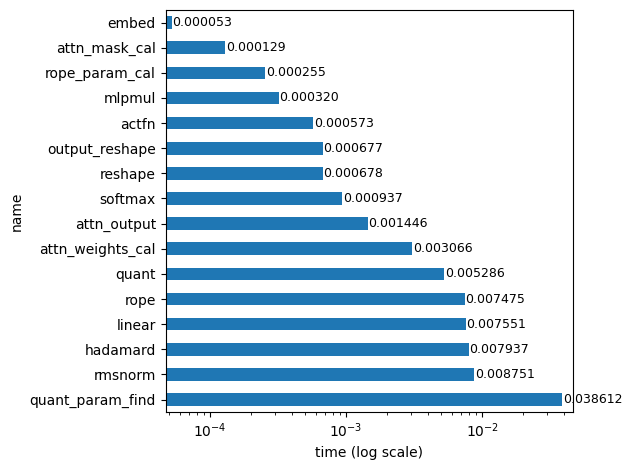

PREFILL: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0844025611877 0.0785431861877
top.apply_rope                                                                   32         0.0307159423828 0.0234370231628
top.vproj                                                                        32         0.0200791358948 0.0160553455353
top.apply_rope.k_head_quantize                                                   32         0.0181355476379 0.0158619880676
top.apply_rope.k_head_quantize.find_params                                       32         0.0133426189423 0.0000000000000
top.vproj.find_params                                                            32         0.0128383636475 0.0110759735107
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


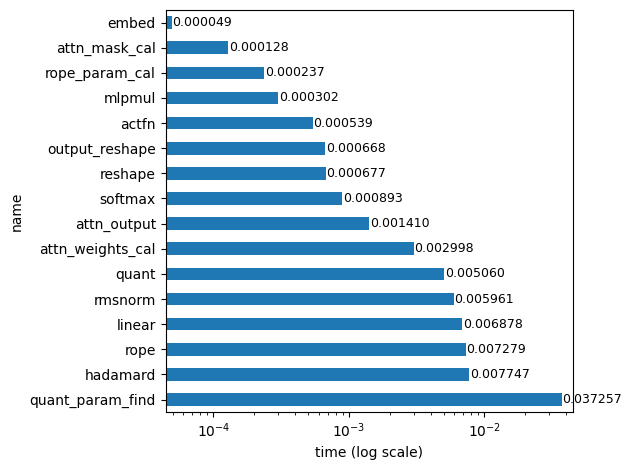

PREFILL: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0974407196045 0.0915918350220
top.apply_rope                                                                   32         0.0317628383636 0.0244443416595
top.vproj                                                                        32         0.0317275524139 0.0278141498566
top.apply_rope.k_head_quantize                                                   32         0.0190763473511 0.0167782306671
top.vproj.asmy_ste_quantize                                                      32         0.0138165950775 0.0000000000000
top.apply_rope.k_head_quantize.find_params                                       32         0.0136466026306 0.0000000000000
top.vproj.find_params                                                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


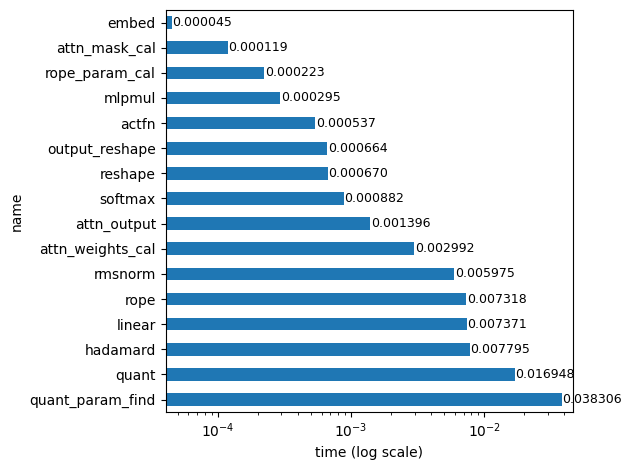

PREFILL: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.1299788951874 0.1241042613983
top.vproj                                                                        32         0.0579383373260 0.0540139675140
top.vproj.asmy_ste_quantize                                                      32         0.0402598381042 0.0000000000000
top.apply_rope                                                                   32         0.0336613655090 0.0263934135437
top.apply_rope.k_head_quantize                                                   32         0.0208621025085 0.0185346603394
top.apply_rope.k_head_quantize.find_params                                       32         0.0135831832886 0.0000000000000
top.vproj.find_params                                                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


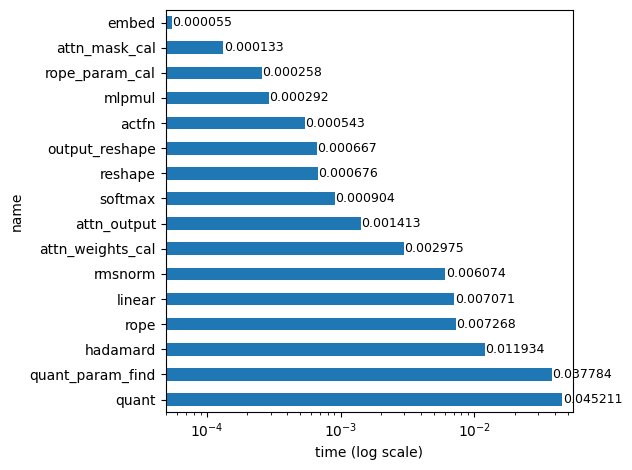

GENERATE: bs 4, sl 8
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0822248458862 0.0753955841064
top.apply_rope                                                                   32         0.0294079780579 0.0223250389099
top.vproj                                                                        32         0.0197854042053 0.0158653259277
top.apply_rope.k_head_quantize                                                   32         0.0178513526917 0.0156214237213
top.apply_rope.k_head_quantize.find_params                                       32         0.0130972862244 0.0000000000000
top.vproj.find_params                                                            32         0.0126962661743 0.0109360218048
top.vproj.find_params.find_params_per_token_groupwise                            3

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


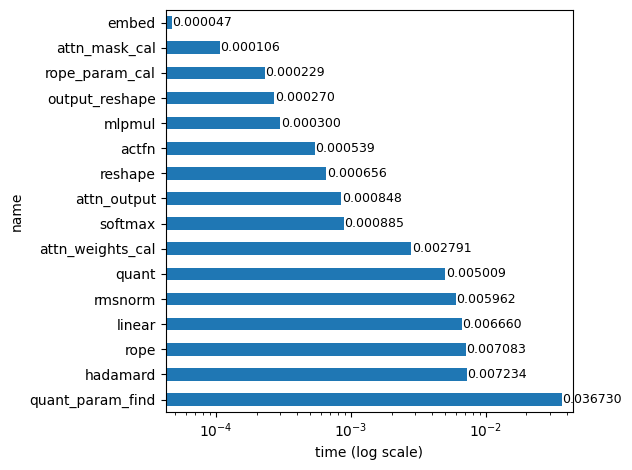

GENERATE: bs 4, sl 16
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0821149349213 0.0753357410431
top.apply_rope                                                                   32         0.0294437408447 0.0223197937012
top.vproj                                                                        32         0.0197329521179 0.0158138275146
top.apply_rope.k_head_quantize                                                   32         0.0178720951080 0.0156326293945
top.apply_rope.k_head_quantize.find_params                                       32         0.0130841732025 0.0000000000000
top.vproj.find_params                                                            32         0.0126507282257 0.0108957290649
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


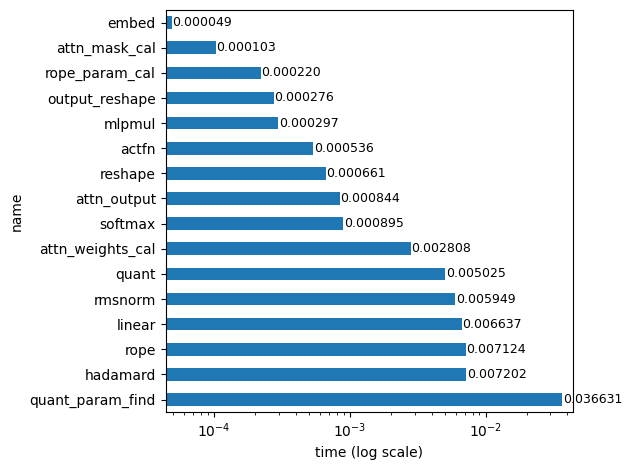

GENERATE: bs 4, sl 32
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0828025341034 0.0760138034821
top.apply_rope                                                                   32         0.0298683643341 0.0226798057556
top.vproj                                                                        32         0.0198655128479 0.0158998966217
top.apply_rope.k_head_quantize                                                   32         0.0182092189789 0.0159509181976
top.apply_rope.k_head_quantize.find_params                                       32         0.0133662223816 0.0000000000000
top.vproj.find_params                                                            32         0.0127096176147 0.0109260082245
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


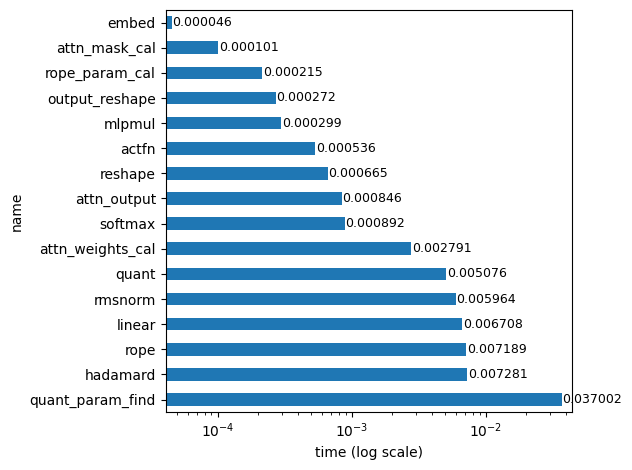

GENERATE: bs 4, sl 64
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0826430320740 0.0755686759949
top.apply_rope                                                                   32         0.0294749736786 0.0223500728607
top.vproj                                                                        32         0.0198435783386 0.0158894062042
top.apply_rope.k_head_quantize                                                   32         0.0179147720337 0.0156967639923
top.apply_rope.k_head_quantize.find_params                                       32         0.0131299495697 0.0000000000000
top.vproj.find_params                                                            32         0.0127186775208 0.0109510421753
top.vproj.find_params.find_params_per_token_groupwise                            

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


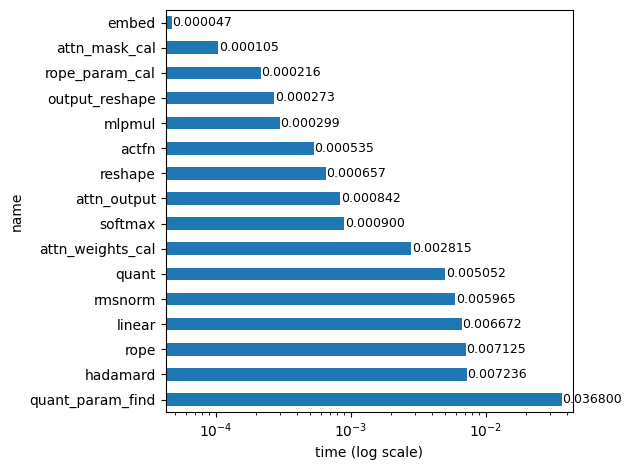

GENERATE: bs 4, sl 128
Warmup...
Start profiling...
Tag                                                                              Calls      Total Time      Cumulative Time
top                                                                              1          0.0862021446228 0.0761842727661
top.apply_rope                                                                   32         0.0296294689178 0.0224661827087
top.vproj                                                                        32         0.0200412273407 0.0160584449768
top.apply_rope.k_head_quantize                                                   32         0.0180099010468 0.0157525539398
top.apply_rope.k_head_quantize.find_params                                       32         0.0131835937500 0.0000000000000
top.vproj.find_params                                                            32         0.0128772258759 0.0110778808594
top.vproj.find_params.find_params_per_token_groupwise                           

/home/jaeyongjang/project.local/SpinQuant/utils/profile.py:163: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  results.append(df[df["Tag"].str.contains(p)])


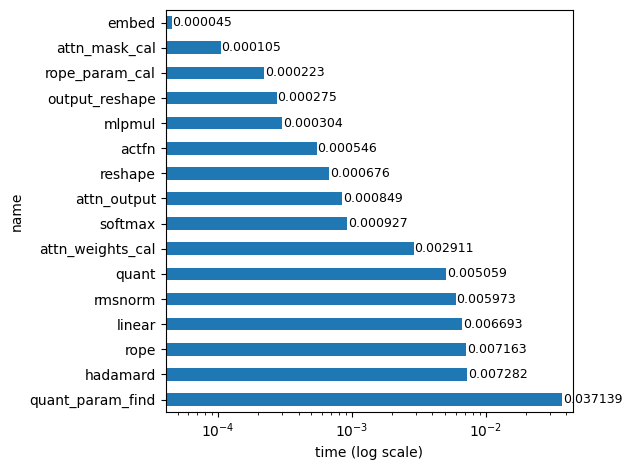

In [41]:
batch_size = [1, 2, 4]
past_seq_len = [8, 16, 32, 64, 128]
seq_len = [8, 16, 32, 64, 128]

for bs in batch_size:
  # prefill
  for sl in seq_len:
    print(f"PREFILL: bs {bs}, sl {sl}")
    run_profile(model, bs, 0, sl, "cuda", f"./prof/bs{bs}_sl{sl}_prf-cuda.png") 
  
  # generate
  for sl in past_seq_len:
    print(f"GENERATE: bs {bs}, sl {sl}")
    run_profile(model, bs, sl, 1, "cuda", f"./prof/bs{bs}_sl{sl}_gen-cuda.png")